<table style="margin-left: 0; border: none; padding: 10px; font-family: Arial, sans-serif; text-align: center;">
  <tr>
    <td style="text-align: left; vertical-align: left;">
      <img src="https://pygraphistry.readthedocs.io/en/latest/_static/graphistry_banner_transparent_colored.png" 
           alt="Graphistry Logo" 
           width="300"> 
    </td>
    <td style="text-align: left; vertical-align: left;">
      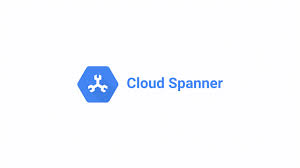
    </td>
  </tr>
</table>


# Demo Notebook - Graphistry and Google Spanner Graph

Graphistry is a cutting-edge platform for large-scale visual graph exploration and analysis. It enables users to intuitively investigate complex relationships, patterns, and anomalies across vast datasets through highly interactive, GPU-accelerated visualizations. Google Cloud Spanner, on the other hand, is a globally distributed, horizontally scalable, and strongly consistent database ideal for managing large, interconnected datasets.

This interactive guide demonstrates how to combine the power of Graphistry's visual graph analytics and AI with the robust data capabilities of Google Cloud Spanner Graph.

Together, these technologies empower you to:

- **Visualize Complex Graphs:** Easily explore relationships and uncover insights in your data through rich visual representations.  
- **Handle Large Datasets:** Leverage Cloud Spanner’s ability to manage vast amounts of interconnected information with strong consistency and scalability.  
- **Perform Advanced Analytics:** Apply graph-based algorithms and clustering techniques to extract actionable insights from structured data.

This demo is designed for:

- **Data Scientists:** Interested in adding visual graph analytics to their toolkit.  
- **Database Engineers:** Looking to integrate graph capabilities into their Cloud Spanner workflows.  
- **Application Developers:** Prototyping applications built using Graphistry and Google Spanner.

This notebook showcases:

1. **Connecting to Cloud Spanner:** How to retrieve and preprocess data from Cloud Spanner for graph processing.  
2. **Graph Visualization with Graphistry:** Turning raw data into meaningful visualizations to explore relationships and clusters.  
3. **Real-World Use Cases:** Applying these tools to solve practical problems.

## Prerequisites

- A Google Cloud account with access to Cloud Spanner.  
- A Graphistry Enterprise Server or free-tier [Graphistry Hub account](https://www.graphistry.com/get-started).  
- Python environment with Graphistry and gcloud spanner support (see pip install below).  
- This demo is based on [FinGraph sample graph](https://codelabs.developers.google.com/codelabs/spanner-graph-getting-started#0).

### Let’s Get Started!

Dive in and see how the synergy of Graphistry and Google Cloud Spanner can transform your data exploration and analysis workflows.


In [2]:
import os
import graphistry
graphistry.__version__

'0.38.2+2.g6f1ae473.dirty'

## Graphistry register and gcloud init

In [3]:
# graphistry register 

# To specify Graphistry account & server, use:
# graphistry.register(api=3, username='...', password='...', protocol='https', server='hub.graphistry.com')
# For more options, see https://pygraphistry.readthedocs.io/en/latest/server/register.html

import os 

graphistry.register(api=3,  
                    protocol  = "https", 
                    server    = os.getenv("GRAPHISTRY_SERVER"),
                    username  = os.getenv("GRAPHISTRY_USERNAME"),
                    password  = os.getenv("GRAPHISTRY_PASSWORD"))

## Configure Spanner

In [ ]:
SPANNER_INSTANCE_ID = os.getenv("SPANNER_INSTANCE_ID") or "finance-graph-instance"
SPANNER_DATABASE_ID = os.getenv("SPANNER_DATABASE_ID") or "finance-graph-db"

# Option 1: Project ID is required for interactive login
SPANNER_PROJECT_ID = os.getenv("SPANNER_PROJECT_ID") or "finance-graph-project"

# Option 2: use a service account key: 
# SPANNER_SERVICE_ACCOUNT_JSON_PATH = os.getenv("SPANNER_SERVICE_ACCOUNT_JSON_PATH") or "path/to/credentials.json"

In [ ]:
# Set the google project id for interactive login

# !gcloud config set project {SPANNER_PROJECT_ID}
# %env GOOGLE_CLOUD_PROJECT={SPANNER_PROJECT_ID}

#!gcloud auth application-default login

In [5]:
# Option 1: interactive login using gcloud auth application-default login (below)
graphistry.configure_spanner(
    project_id=SPANNER_PROJECT_ID,
    instance_id=SPANNER_INSTANCE_ID,
    database_id=SPANNER_DATABASE_ID
)


# Option 2: use a service account key: 
# graphistry.configure_spanner(
#     instance_id=SPANNER_INSTANCE_ID,
#     database_id=SPANNER_DATABASE_ID,
#     credentials_file=SPANNER_SERVICE_ACCOUNT_JSON_PATH
# )



# optional setting to limit the number of records returned
LIMIT_CLAUSE = ""
# or use: 
# LIMIT_CLAUSE = "limit 1000" 

## Example 1: GQL Path Query to Graphistry Visualization of all nodes and edges (LIMIT optional) 

to extract the data from Spanner Graph as a graph with nodes and edges in a single object, a GQL path query is required. 

The format of a path query is as follows, note the p= at the start of the MATCH clause, and the SAFE_TO_JSON(p) without these, 
the query will not produce the results needed to properly load a graphistry graph. LIMIT is optional, but for large graphs with millions
        of edges or more, it's best to filter either in the query or use LIMIT so as not to exhaust GPU memory.  

```
GRAPH FinGraph
MATCH p = (a)-[b]->(c) where 1=1 LIMIT 10000 return SAFE_TO_JSON(p) as path
```


In [6]:
query=f'''GRAPH FinGraph
MATCH p = (a)-[b]->(c) where 1=1 {LIMIT_CLAUSE} return SAFE_TO_JSON(p) as path'''

g = graphistry.spanner_gql(query)

In [7]:
g.plot()

### Example 1.1 - inspect contents of graphistry graph (nodes and edges): 

In [8]:
len(g._nodes), len(g._edges)

(1312, 1700)

In [9]:
g._nodes.head(3)

,label,identifier,create_time,id,is_blocked,type_,balance,interest_rate,loan_amount,name,type
0,Account,mUZpbkdyYXBoLkFjY291bnQAeJEC,2020-01-10T14:22:20.222Z,1,False,brokerage account,NaN,NaN,NaN,NaN,Account
1,Loan,mUZpbkdyYXBoLkxvYW4AeJIBMA==,2021-04-12T02:01:54.223Z,152,NaN,NaN,112149.8,0.035,2492216.8,NaN,Loan
4,Account,mUZpbkdyYXBoLkFjY291bnQAeJEK,2020-03-02T20:47:18.726Z,5,False,brokerage account,NaN,NaN,NaN,NaN,Account


In [10]:
g._edges.head(3)

,label,identifier,source,destination,amount,create_time,id,loan_id,to_id,account_id,type
0,Repays,mUZpbkdyYXBoLkFjY291bnRSZXBheUxvYW4AeJECkgEwmY...,mUZpbkdyYXBoLkFjY291bnQAeJEC,mUZpbkdyYXBoLkxvYW4AeJIBMA==,36633.6,2022-03-08T05:27:06.265Z,1,152.0,NaN,NaN,Repays
1,Repays,mUZpbkdyYXBoLkFjY291bnRSZXBheUxvYW4AeJECkgEwmY...,mUZpbkdyYXBoLkFjY291bnQAeJEC,mUZpbkdyYXBoLkxvYW4AeJIBMA==,22836.6,2022-05-02T12:40:52.562Z,1,152.0,NaN,NaN,Repays
2,Repays,mUZpbkdyYXBoLkFjY291bnRSZXBheUxvYW4AeJEKkSyZgA...,mUZpbkdyYXBoLkFjY291bnQAeJEK,mUZpbkdyYXBoLkxvYW4AeJEs,15999.3,2022-03-14T21:28:25.972Z,5,22.0,NaN,NaN,Repays


## Example 2: Quantified path traversal 
(slightly modified from example to use a path query for visualization)

from: [spanner-graph-getting-started](https://codelabs.developers.google.com/codelabs/spanner-graph-getting-started#6)

**Query 2** - Quantified path traversal and return graph elements

The following query matches all account money transfers starting from a source account with id=75 within 3 to 6 hops, to reach a destination account with id=199. The {3,6} syntax is used to represent a quantified 3 to 6 hop path traversal between src_accnt and dst_accnt.

```
GRAPH FinGraph
MATCH
p = (src_accnt:Account {id:75})-[transfers:Transfers]->{3,6}
  (dst_accnt:Account {id:199})  
RETURN SAFE_TO_JSON(p) as path
```

Visually, you can think of the quantified edge traversal like below: it starts from a src_account node, and fetches all possible account transfer paths between 3 to 6 hops, to reach dst_account.

The highlighted path at the bottom below, for example, is a 6-hop query.

![query2](https://codelabs.developers.google.com/static/codelabs/spanner-graph-getting-started/img/8165a85878d957ef_856.png)

source: https://codelabs.developers.google.com/static/codelabs/spanner-graph-getting-started/#6


In [11]:
query2='''GRAPH FinGraph
MATCH
p = (src_accnt:Account {id:75})-[transfers:Transfers]->{3,6}
  (dst_accnt:Account {id:199}) where 1=1 
RETURN SAFE_TO_JSON(p) as path
'''

In [12]:
g2 = graphistry.spanner_gql(query2)
g2.plot()

In [13]:
#  now run again and retrive all the paths 
query2a='''GRAPH FinGraph
MATCH
p = (src_accnt:Account )-[transfers:Transfers]->{3,6}
  (dst_accnt:Account ) where 1=1 
RETURN SAFE_TO_JSON(p) as path
'''
g2a = graphistry.spanner_gql(query2a)
g2a.plot()

## Example 3: Spanner GQL Tabular Query to pandas dataframe (LIMIT optional) 

This example shows a non-path query that returns tabular results, which are then convered to a dataframe for easy manipulation and inspection of the results. 

```
GRAPH FinGraph 
MATCH (p:Person)-[]-()->(l:Loan)
RETURN p.id as ID, p.name AS Name, SUM(l.loan_amount) AS TotalBorrowed
ORDER BY TotalBorrowed DESC
LIMIT 10```



In [14]:
query_top10='''GRAPH FinGraph 
MATCH (p:Person)-[:Owns]-(:Account)->(l:Loan) WHERE 1=1
RETURN p.id as ID, p.name AS Name, SUM(l.loan_amount) AS TotalBorrowed
ORDER BY TotalBorrowed DESC
LIMIT 10'''

In [15]:
Top10_Borrowers_df = graphistry.spanner_gql_to_df(query_top10)

In [16]:
Top10_Borrowers_df.head(10)

,ID,Name,TotalBorrowed
0,337,Tutmarc,15269003.6
1,484,Greiner,14098853.6
2,370,Morrisseau,13912146.2
3,113,Paakkonen,13022928.4
4,416,Greif,12713990.0
5,68,Cabon,12256398.8
6,66,Stinson,11462716.8
7,46,Riby,10772732.5
8,406,Jöhncke,10470230.8
9,169,Gubenko,10330528.5


## Example 4: Spanner SQL Query to pandas dataframe 

This example shows a SQL query to Spanner that returns tabular results, which are then convered to a dataframe for easy manipulation and inspection of the results. 

### Query: 
```sql
SELECT * from Account
```


![Cloudblog image](https://storage.googleapis.com/gweb-cloudblog-publish/images/Fig2.max-1000x1000.png)


source: https://cloud.google.com/blog/products/databases/announcing-spanner-graph


In [17]:
accounts_df =  graphistry.spanner_gql_to_df('SELECT * from Account')

In [18]:
accounts_df.head(10)

,id,create_time,is_blocked,type
0,1,2020-01-10 14:22:20.222000+00:00,False,brokerage account
1,2,2020-01-28 01:55:09.206000+00:00,False,prepaid card
2,3,2020-02-18 13:44:20.655000+00:00,False,brokerage account
3,4,2020-02-29 16:49:53.902000+00:00,False,debit card
4,5,2020-03-02 20:47:18.726000+00:00,False,brokerage account
5,6,2020-03-21 22:25:34.327000+00:00,False,custodial account
6,7,2020-04-14 00:53:48.932000+00:00,False,brokerage account
7,8,2020-04-15 03:08:15.427000+00:00,True,trust account
8,9,2020-04-20 13:20:25.717000+00:00,False,certificate of deposit
9,10,2020-04-26 00:12:17.773000+00:00,False,debit card


## Example 5: Spanner SQL Query to inspect the database schema

This example shows a SQL query to Spanner that retrieves the tables, columns and types from the information schema in Spanner. This can be helpful for seeing what's available in the database or using this data as part of a workflow. 
<br>

```sql
SELECT table_name, column_name, spanner_type FROM information_schema.columns
```

In [19]:
columns_df =  graphistry.spanner_gql_to_df('SELECT table_name, column_name, spanner_type FROM information_schema.columns')
columns_df.head(10)

,table_name,column_name,spanner_type
0,Account,id,INT64
1,Account,create_time,TIMESTAMP
2,Account,is_blocked,BOOL
3,Account,type,STRING(MAX)
4,AccountAudits,id,INT64
5,AccountAudits,audit_timestamp,TIMESTAMP
6,AccountAudits,audit_details,STRING(MAX)
7,AccountRepayLoan,id,INT64
8,AccountRepayLoan,loan_id,INT64
9,AccountRepayLoan,amount,FLOAT64


In [20]:
len(columns_df.table_name.unique())

100

In [21]:
query_tables='''
SELECT table_name, table_type
FROM information_schema.tables
WHERE table_catalog = ''
  AND table_schema = ''
  AND table_type IN ('BASE TABLE', 'VIEW');
'''

tables_df = graphistry.spanner_gql_to_df(query_tables)
tables_df

,table_name,table_type
0,Account,BASE TABLE
1,AccountAudits,BASE TABLE
2,AccountRepayLoan,BASE TABLE
3,AccountTransferAccount,BASE TABLE
4,Loan,BASE TABLE
5,Person,BASE TABLE
6,PersonOwnAccount,BASE TABLE


## Continue your Graph and AI journey...

### Graphistry
Get started with PyGraphistry and explore AI-powered visual analytics:

- [10 minutes to PyGraphistry](https://github.com/graphistry/pygraphistry/blob/master/demos/10-mins-to-pygraphistry.ipynb)
- [Graphistry: Get Started](https://www.graphistry.com/get-started) - Learn how to leverage Graphistry for your projects.
- [Louie AI](https://louie.ai) - AI-powered data insights and visualization.
- [Join our Community Slack](https://www.graphistry.com/support) - Get support and insights from experts.

### Google Spanner
Explore Google Spanner graph features, documentation, and use cases:

- [Google Spanner Python Documentation](https://cloud.google.com/python/docs/reference/spanner/latest) - Official Python client library for Google Spanner.
- [Spanner Graph Codelab](https://codelabs.developers.google.com/codelabs/spanner-graph-getting-started) - Hands-on tutorial for getting started with Spanner graph features.
- [Google Spanner Graph Overview](https://cloud.google.com/spanner/docs/graph/overview) - Learn about Spanner's graph processing capabilities.
- [Graph Queries Overview](https://cloud.google.com/spanner/docs/graph/queries-overview) - Understand how to query graph data in Spanner.
- [Graph Query Statements](https://cloud.google.com/spanner/docs/reference/standard-sql/graph-query-statements) - Reference guide for writing graph queries in Spanner.
- [Schema and Data Model](https://cloud.google.com/spanner/docs/schema-and-data-model)
